In [1]:
%run -i "loaddata.py"
plt.rcParams["font.size"] = 13
import scipy.stats as st
save = False

What is your name? [Simone/Jonathan/Marcus/Runi]Jonathan


### The timeseries

In [2]:
all_keys = tuple(data_dict.keys())
keys = [all_keys[i] for i in range(len(all_keys)) if i%2==0]

x = np.array([data_dict[keys[i]][:,0] for i in range(len(keys))])
y = np.array([data_dict[keys[i]][:,1] for i in range(len(keys))])

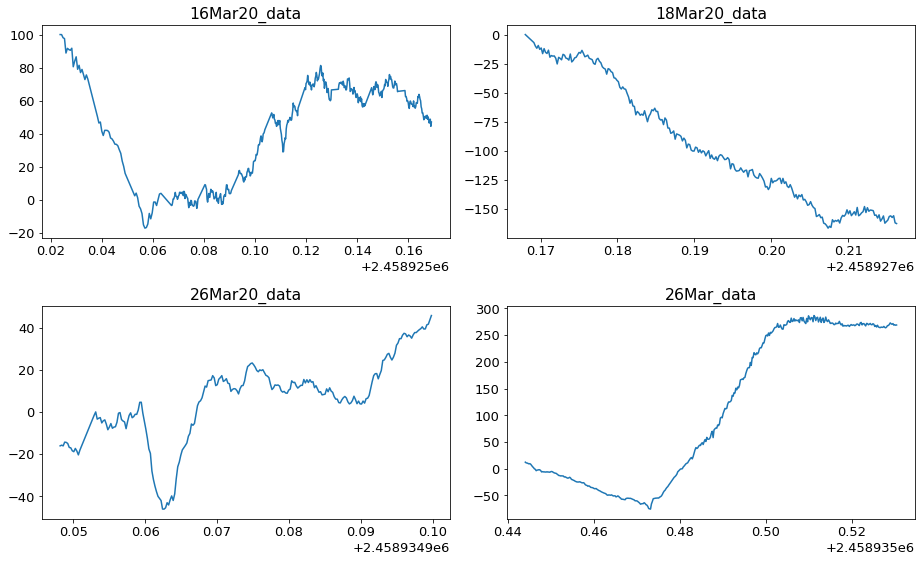

In [3]:
plt.figure(figsize=(13,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(keys[i])
    plt.plot(x[i], y[i])
plt.tight_layout()
plt.show()

### Stacked histograms of feature distributions

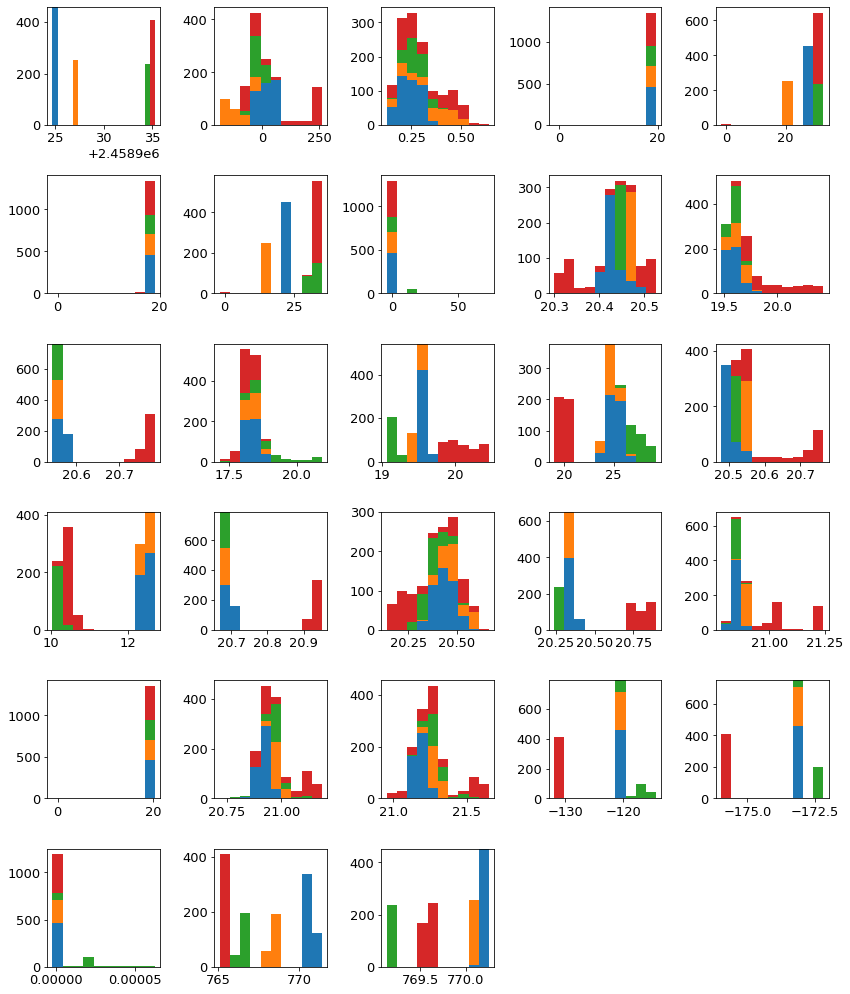

In [4]:
fig = plt.figure(figsize=(12,14))
for i in range( data_dict[keys[0]].shape[1] ):
    plt.subplot(6,5,i+1)
    if i == 0:
        plt.hist([data_dict[keys[0]][:,i], data_dict[keys[1]][:,i], data_dict[keys[2]][:,i], data_dict[keys[3]][:,i]], 
                 histtype='barstacked', align='left', bins=20)
    else:
        plt.hist([data_dict[keys[0]][:,i], data_dict[keys[1]][:,i], data_dict[keys[2]][:,i], data_dict[keys[3]][:,i]], 
                 histtype='barstacked', align='left')
plt.tight_layout()
plt.show()

if save:
    fig.savefig("figs/features_hist.pdf")

### t-SNE

In [5]:
def remove_nan(X, y):
    remove = np.isnan(X)[:,0]
    remove1 = [i for i in range(len(remove)) if remove[i]==False]
    return X[remove1,:], y[remove1]

In [6]:
from sklearn.manifold import TSNE
# Collect all data in a single array
data = data_dict[keys[0]]
for i in range(1,4):
    data = np.append(data, data_dict[keys[i]],axis=0)
    
y_labels = data[:,1]
X = data[:,3:]

# Remove nan
X, y_labels = remove_nan(X, y_labels)

tsne = TSNE(n_components = 2, n_jobs=-1, verbose=0, random_state=42)
tsne_data = tsne.fit_transform(X)

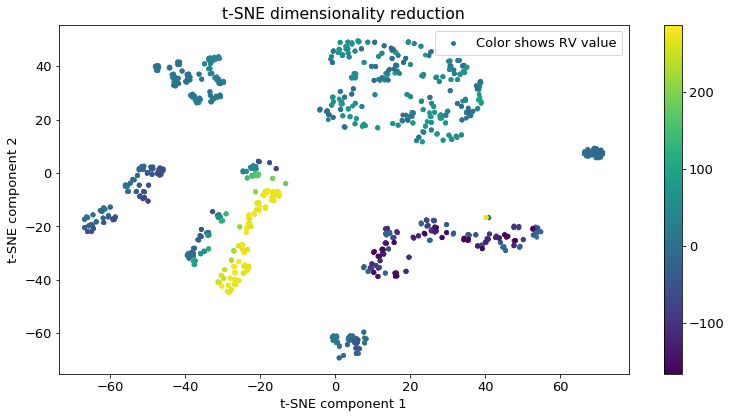

In [7]:
fig = plt.figure(figsize=(11,6))
plt.title("t-SNE dimensionality reduction")
plt.scatter(tsne_data[:,0], tsne_data[:,1], s=15, c = y_labels, label="Color shows RV value")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.colorbar()
plt.legend()
plt.tight_layout()
plt.show()

if save:
    fig.savefig("figs/t-SNE.pdf")

### XGBoost

In [18]:
# Sort out the data in train and test
data_train = data_dict[keys[1]]
data_train = np.append(data_train, data_dict[keys[2]], axis=0)
data_train = np.append(data_train, data_dict[keys[3]], axis=0)

data_test = data_dict[keys[0]]

X_train = data_train[:,3:]
y_train = data_train[:,1]
X_test = data_test[:,3:]
y_test = data_test[:,1]

X_train, y_train = remove_nan(X_train, y_train)
X_test, y_test = remove_nan(X_test, y_test)

In [19]:
import xgboost as xgb

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

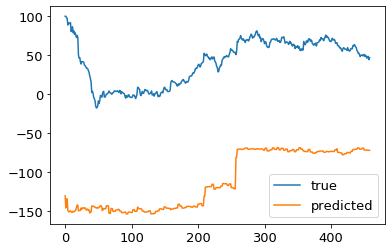

In [20]:
plt.figure()
plt.plot(y_test, label="true")
plt.plot(y_pred,label="predicted")
plt.legend()
plt.show()

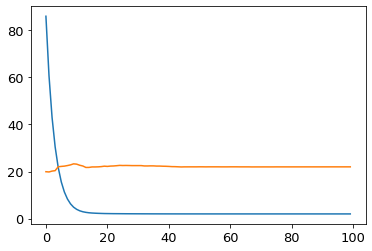

In [11]:
results = model.evals_result()
plt.plot(results['validation_0']["rmse"])
plt.plot(results['validation_1']["rmse"])
plt.show()

In [12]:
from sklearn.model_selection import RandomizedSearchCV

# Create a model with no hyperparameters
CV = xgb.XGBRegressor()

# Parameters to search
parameters_RandomSearch = {'num_round': st.randint(1,50),
                           'eta': st.uniform(),
                           'max_depth': st.randint(1,50)}
# Number of search rounds
n_iter_search = 20

# Initialize
RandomSearch = RandomizedSearchCV(CV, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  verbose = 2, 
                                  n_jobs = -1)

# fit the random search instance
RandomSearch.fit(X_train, y_train)

# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s


Random Search: 	Best parameters:  {'eta': 0.48940264608510886, 'max_depth': 37, 'num_round': 30} , Best scores: -3.459


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished


In [13]:
y_pred = RandomSearch.predict(X_test)

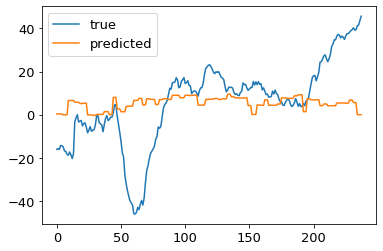

In [14]:
plt.figure()
plt.plot(y_test, label="true")
plt.plot(y_pred,label="predicted")
plt.legend()
plt.show()

### Try new type of train/test

In [21]:
# Sort out the data in train and test
half_length = int(len(data_dict[keys[2]])//2)

data_train = data_dict[keys[0]]
data_train = np.append(data_train, data_dict[keys[1]], axis=0)
data_train = np.append(data_train, data_dict[keys[3]], axis=0)
data_train = np.append(data_train, data_dict[keys[2]][:half_length,:], axis=0)

data_test = data_dict[keys[2]][half_length:,:]

X_train = data_train[:,3:]
y_train = data_train[:,1]
X_test = data_test[:,3:]
y_test = data_test[:,1]

X_train, y_train = remove_nan(X_train, y_train)
X_test, y_test = remove_nan(X_test, y_test)

In [22]:
model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

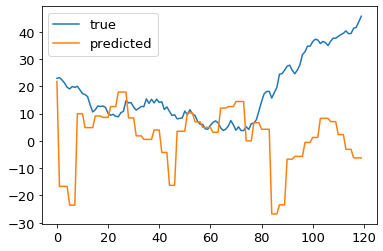

In [23]:
plt.figure()
plt.plot(y_test, label="true")
plt.plot(y_pred,label="predicted")
plt.legend()
plt.show()